# Researching csv data

In current investigation the author is going to parse date from <code>yc_csv.csv</code> and get some conclusions about what is needed for successful startup.

## First glances at dataframe

In [405]:
import pandas as pd
df = pd.read_csv("assets/yc_csv.csv")

In [406]:
df

,xid,#,Companies,Company ID,Deal ID,Deal Date,Announced Date,Deal Size,Pre-money Valuation,Post Valuation,...,Lead/Sole Investors,Employees,Revenue Growth since last debt deal,Revenue,EBITDA,Total Debt (from financials),Deal Synopsis,Financing Status Note,CEO (at time of deal),CEO PBId
0,48635,48386,Parakey (Software Development Applications),52732-99,19117-54T,17/11/2006 00:00,NaN,1.56,13.27,14.83,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $1.56 million of Series A f...,The company was acquired by Facebook (NASDAQ: ...,{'62492-86P': 'Blake Ross'},62492-86P
1,58836,58587,Snaptalent,61729-75,32010-85T,01/01/2008 00:00,NaN,2.00,4.03,6.03,...,NaN,NaN,NaN,NaN,NaN,NaN,The company joined Y Combinator as part of the...,The company is no longer actively in business ...,NaN,NaN
2,60141,59892,FriendFeed,41728-33,19653-94T,25/02/2008 00:00,NaN,5.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $5 million of Series A vent...,The company was acquired by Facebook for $50 m...,{'167058-55P': 'Jim Norris'},167058-55P
3,64785,64536,RescueTime,52794-46,135800-20T,23/09/2008 00:00,NaN,0.90,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"The company raised $900,000 of seed funding fr...","True Ventures, Y Combinator, Lowercase Capital...",{'43621-03P': 'Brian Fioca'},43621-03P
4,66671,66422,CarWoo,51122-80,18676-81T,01/01/2009 00:00,NaN,1.93,2.69,4.62,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $1.9 million of seed fundin...,The company is no longer actively in business ...,{'38143-27P': 'Robert McClung'},38143-27P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,314141,313892,Reflex (Software Development Applications),520530-40,223029-82T,02/08/2023 00:00,NaN,5.00,NaN,NaN,...,{'11229-04': 'Lux Capital'},NaN,NaN,NaN,NaN,NaN,The company raised $5 million of seed funding ...,The company raised $5 million of seed funding ...,{'336293-83P': 'Nikhil Rao'},336293-83P
1343,314262,314013,MindsDB,223449-22,212197-42T,08/08/2023 00:00,07/02/2023 00:00,46.50,NaN,NaN,...,{'11133-01': 'Benchmark (San Francisco) (Cheta...,NaN,NaN,NaN,NaN,NaN,The company raised $46.5 million of Series A v...,The company raised $46.5 million of Series A v...,{'100780-12P': 'Jorge Torres'},100780-12P
1344,314273,314024,Daybreak Health,434212-21,233351-02T,08/08/2023 00:00,NaN,13.00,52.00,65.00,...,{'11323-45': 'Union Square Ventures'},NaN,NaN,NaN,NaN,NaN,The company raised $13 million of Series B ven...,The company raised $13 million of Series B ven...,{'227761-57P': 'Alex Alvarado'},227761-57P
1345,314428,314179,Arpio,435028-33,219305-98T,14/08/2023 00:00,28/07/2023 00:00,8.20,NaN,NaN,...,"{'342995-41': 'Companyon Ventures', '42943-96'...",NaN,NaN,NaN,NaN,NaN,The company raised $7.98 million of seed fundi...,The company raised $7.98 million of seed fundi...,{'229843-99P': 'Douglas Neumann'},229843-99P


In [407]:
import json
import numpy as np

In [408]:
investors_amount = []
investors_keys_values = {}
for index, row in df.iterrows():
    current_investors = json.loads(row["Investors"].replace(" '", ' "').replace("',", '",').replace("'}", '"}').replace("{'", '{"').replace("':", '":'))
    investors_keys_values = {**investors_keys_values, **current_investors}
len(investors_keys_values)

5238

## Research itself

In [409]:
companies = df["Companies"]
len(companies)

1347

Let's get an amount of active companies in the table. We will consider that company is active if it didnot stop its independent existence (inactive or aquired).

In [410]:
def is_active(row):
    return "The company is no longer actively in business" not in row["Financing Status Note"] and \
    "The company was acquired" not in row["Financing Status Note"] and\
    "The company went out of business" not in row["Financing Status Note"]
    

In [411]:

active_companies_counter = 0
for index, row in df.iterrows():
    if is_active(row):
        active_companies_counter += 1
active_companies_counter

1092

Let's count an average amount of investors for active companies:

In [412]:
investors_amount = []
for index, row in df.iterrows():
    investors_amount.append(len(json.loads(row["Investors"].replace(" '", ' "').replace("',", '",').replace("'}", '"}').replace("{'", '{"').replace("':", '":')).keys()))
df.loc[:, "Investors_amount"] = investors_amount

In [413]:
investors_amount_for_active = []
for index, row in df.iterrows():
    if is_active(row):
        investors_amount_for_active.append(row["Investors_amount"])

median_investors_amount = np.median(investors_amount_for_active)
median_investors_amount

9.0

Counting in millions of dollars, an average revenue for active companies is equal to:

In [414]:
import statistics as st

revenue_for_active = []
for index, row in df.iterrows():
    if is_active(row) and pd.notna(row["Revenue"]):
        revenue_for_active.append(row["Revenue"])

average_revenue = st.median(revenue_for_active)
average_revenue

5.04

In [415]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.autumn()

revenue_for_active_sorted = sorted(revenue_for_active)
revenue_np_array = np.array(revenue_for_active_sorted)

<Figure size 640x480 with 0 Axes>

Let's investigate same results in detail. Let's see common histogram:

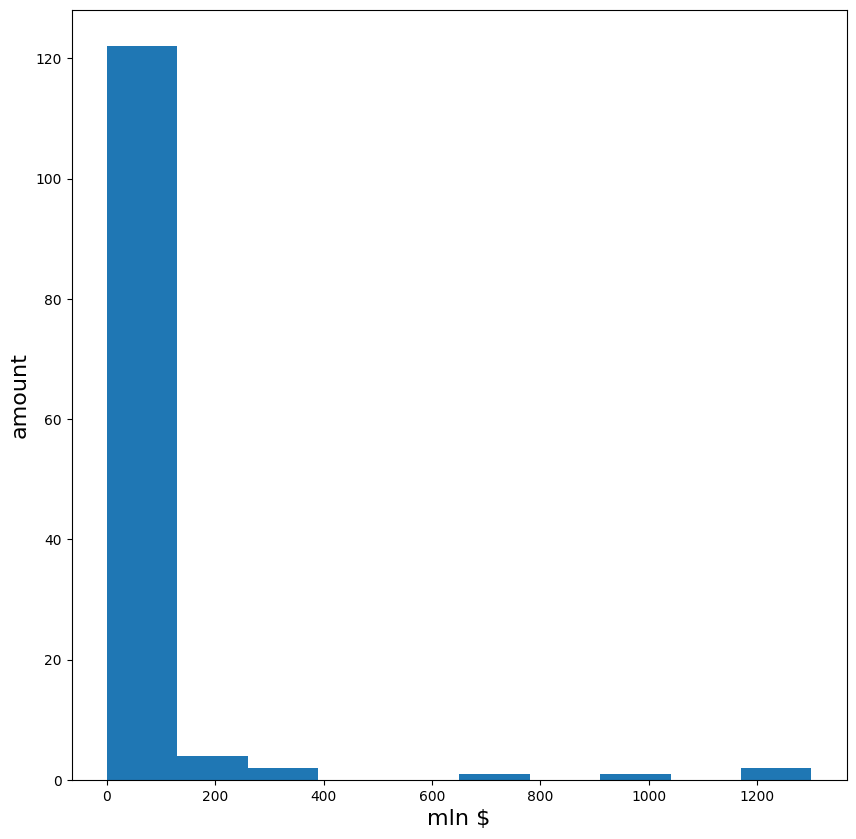

In [417]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(revenue_np_array, histtype='bar')
ax.set_ylabel('amount', size=16)
ax.set_xlabel('mln $', size=16)
plt.show()

Then we will do it for quartiles:

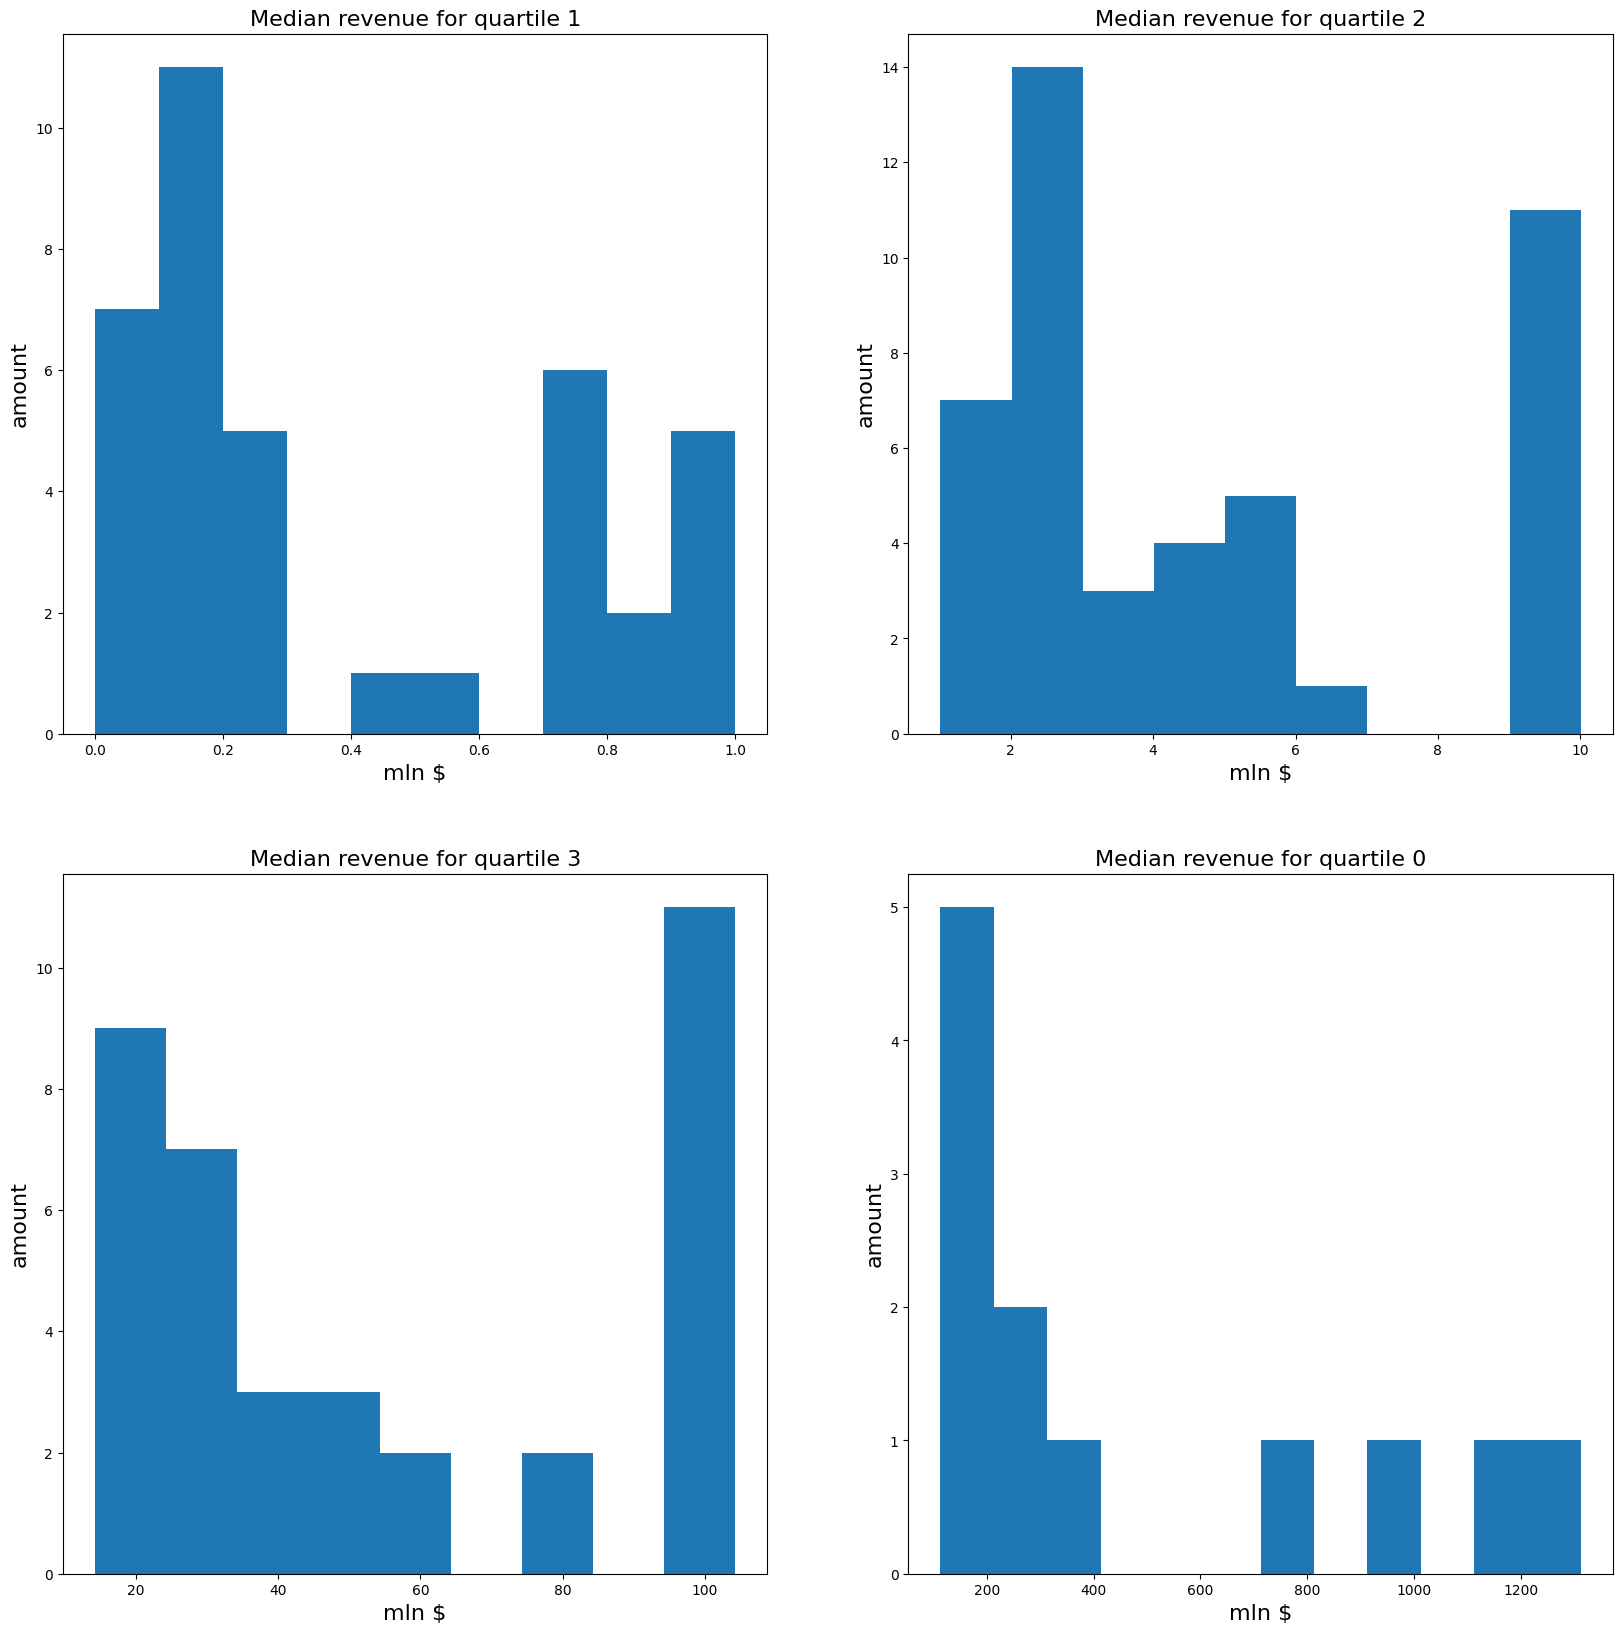

In [421]:
quartiles = []
quartiles.append(np.array([el for el in revenue_np_array if el <= 1.0]))
quartiles.append(np.array([el for el in revenue_np_array if el > 1.0 and el <= 10.0]))
quartiles.append(np.array([el for el in revenue_np_array if el > 10.0 and el <= 100.0]))
quartiles.append(np.array([el for el in revenue_np_array if el > 100.0]))

step = 0.1
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for quartile_idx in range(len(quartiles)):
    plt.title(f"Median revenue for quartile {quartile_idx}", fontsize=16)
    quartile = [el for el in quartiles[quartile_idx]]
    ax = plt.subplot(2, 2, quartile_idx + 1)

    ax.hist(quartile, histtype='bar', bins=np.arange(min(quartile), max(quartile) + step, step))
    step *= 10

    ax.set_ylabel('amount', size=16)
    ax.set_xlabel('mln $', size=16)
plt.show()

Finally, we will do it for deciles:

Thus we can see that there most of companies with revenue from 30 mln \$ to 100 mln \$ among active companies.

Let's count same values for inactive companies on 11-29-2023:

In [423]:
investors_amount_for_notactive = []
for index, row in df.iterrows():
    if not is_active(row):
        investors_amount_for_notactive.append(row["Investors_amount"])

median_investors_amount_notactive = np.median(investors_amount_for_notactive)
median_investors_amount_notactive

10.0

In [424]:
revenues_for_notactive = []
for index, row in df.iterrows():
    if not is_active(row) and pd.notna(row["Revenue"]):
        revenues_for_notactive.append(row["Revenue"])

average_deal_size_notactive = np.median(revenues_for_notactive)
average_deal_size_notactive

1.2

However, we should extimate intervals of time when revenues were got by inactive companies. To calculate this we should get the year of their activity stoppage and take the previous one. Let's get the histogram of these years.

In [425]:
def get_date_of_activity_stoppage(status):
    if "The company was acquired" in status or "The company went out of business":
        result = status.split(" on ", maxsplit=1)
        if len(result) == 2:
            _, substr_with_date = result
        else:
            result = status.split(" in ", maxsplit=1)
            if len(result) == 2:
                _, substr_with_date = result
            else:
                return None
    if "The company is no longer actively in business" in status:
        result = status.split(" of ", maxsplit=1)
        if len(result) == 2:
            _, substr_with_date = result
        else:
            return None

    space_counter = 0
    end = 0
    for letter_idx in range(len(substr_with_date)):
        if substr_with_date[letter_idx] == " " or substr_with_date[letter_idx] == ".":
            space_counter += 1
        if space_counter == 2:
            end = letter_idx + 1

    date = substr_with_date[0:end]
    while not date[-1].isdigit() and len(date) > 0:
        if len(date) == 1:
            return None
        date = date[:len(date) - 1]
    return date

def get_year_of_date(date):
    return int(date[len(date) - 4:])

In [426]:
years_of_activities_stoppage = []
for index, row in df.iterrows():
    if not is_active(row):
        date = get_date_of_activity_stoppage(row["Financing Status Note"])
        if not date:
            continue
        years_of_activities_stoppage.append(get_year_of_date(date) - 1)
print(f'Median for year of activity stoppage is {np.median(years_of_activities_stoppage)}')

Median for year of activity stoppage is 2019.0


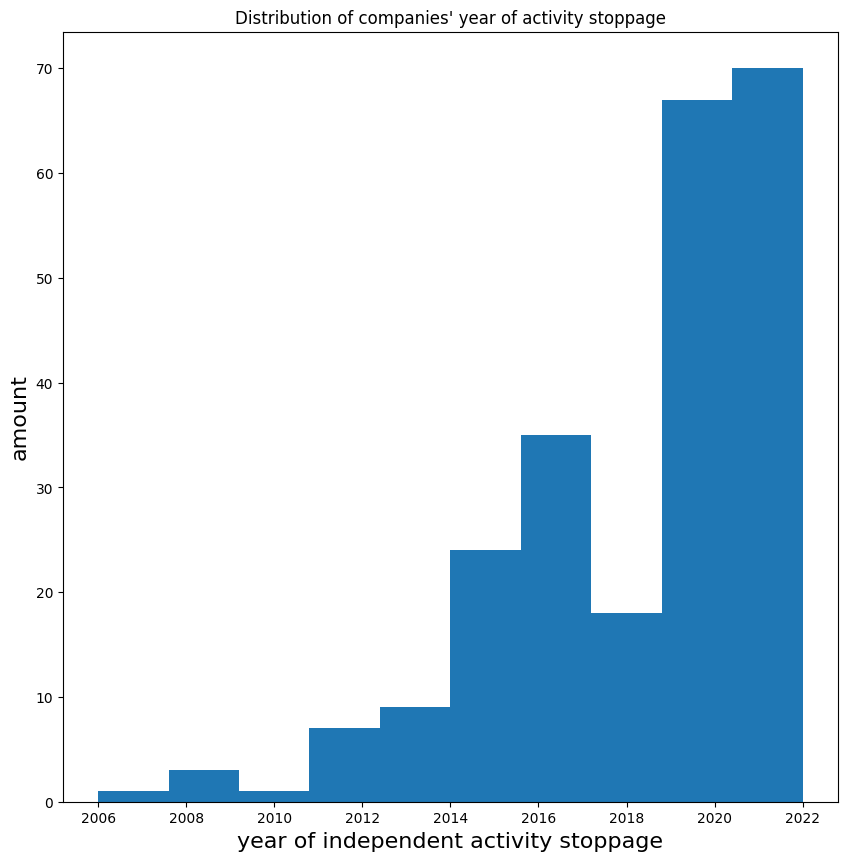

In [427]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title("Distribution of companies' year of activity stoppage")
ax.hist(years_of_activities_stoppage, histtype='bar')
ax.set_ylabel('amount', size=16)
ax.set_xlabel('year of independent activity stoppage', size=16)
plt.show()

We can see that the majority of unactive companies in table stopped their activities in interval of years from 2019 to 2022. Considering that revenues of active companies were got in 2022, we can claim that comparison is quite fair. 

Now let's build histograms for their revenues:

Minimal revenue = 0.0, maximal revenue = 136.0


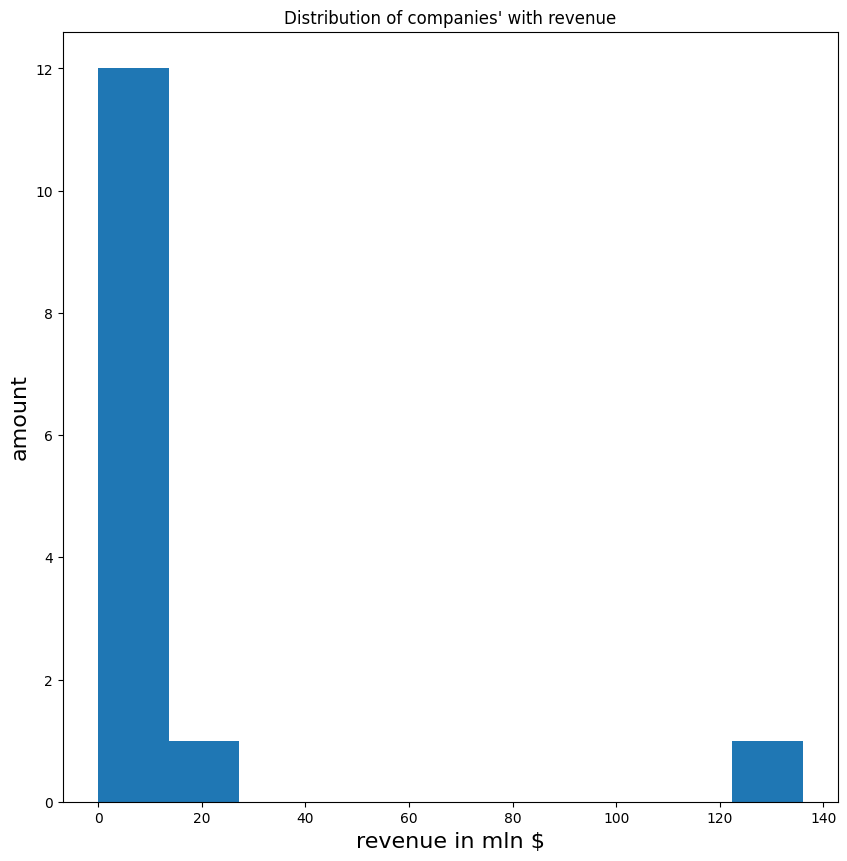

In [428]:
revenue_for_unactive_sorted = sorted(revenues_for_notactive)
revenue_notactive_np_array = np.array(revenue_for_unactive_sorted)

print(f'Minimal revenue = {min(revenue_notactive_np_array)}, maximal revenue = {max(revenue_notactive_np_array)}')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title("Distribution of companies' with revenue")
ax.hist(revenue_notactive_np_array, histtype='bar')
ax.set_ylabel('amount', size=16)
ax.set_xlabel('revenue in mln $', size=16)
plt.show()

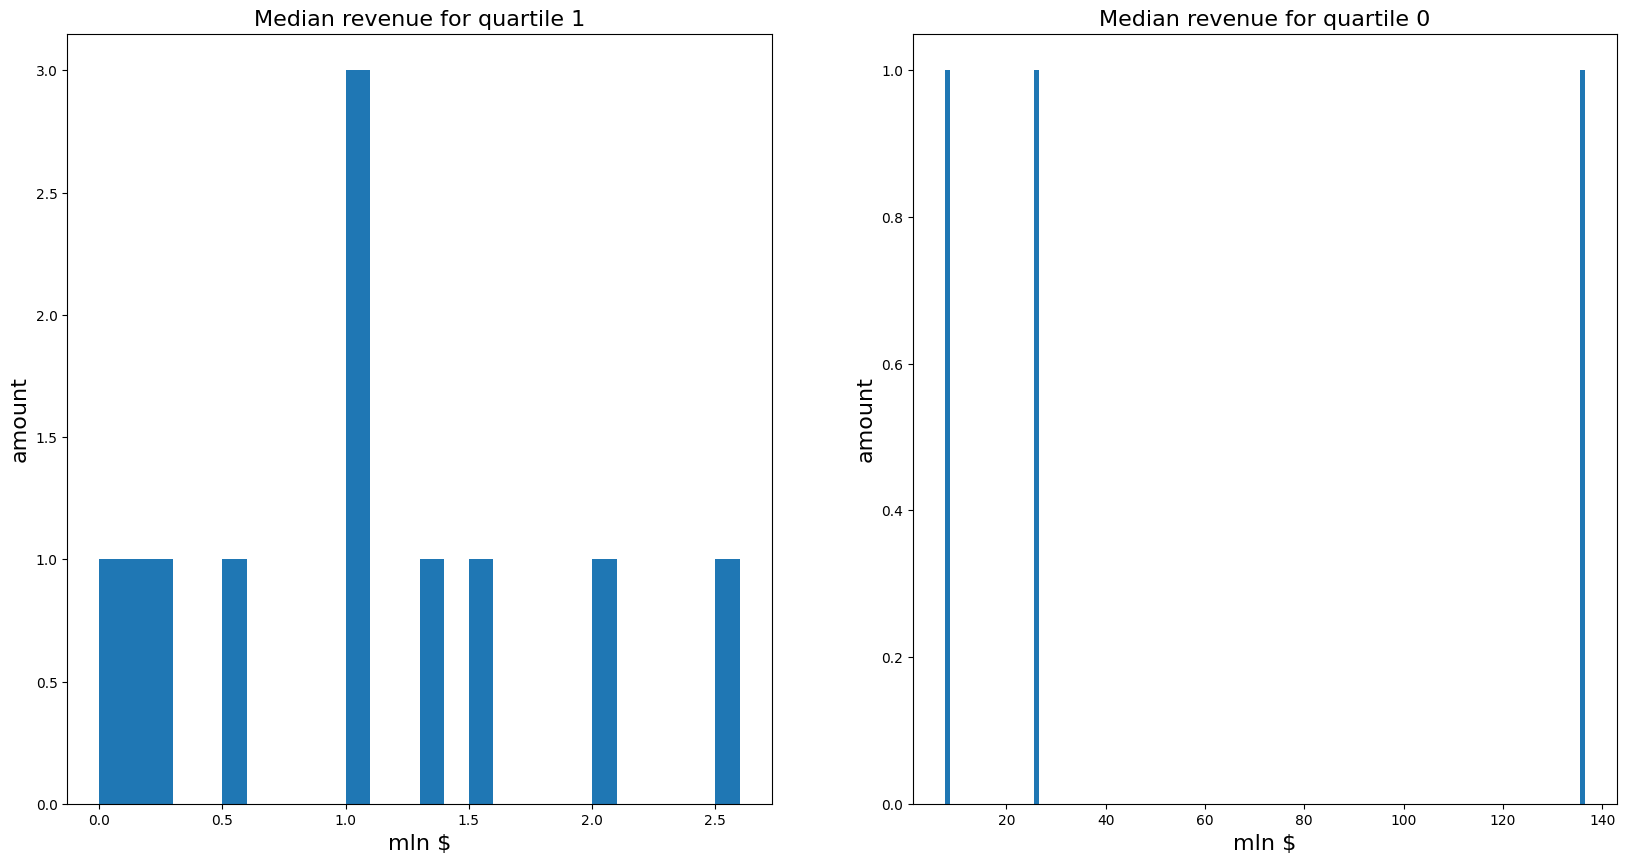

In [434]:
notactive_quartiles = []
notactive_quartiles.append(np.array([el for el in revenue_notactive_np_array if el <= 3.0]))
notactive_quartiles.append(np.array([el for el in revenue_notactive_np_array if el > 3.0]))

step = 0.1
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for quartile_idx in range(len(notactive_quartiles)):
    plt.title(f"Median revenue for quartile {quartile_idx}", fontsize=16)
    quartile = [el for el in notactive_quartiles[quartile_idx]]
    ax = plt.subplot(1, 2, quartile_idx + 1)

    ax.hist(quartile, histtype='bar', bins=np.arange(min(quartile), max(quartile) + step, step))
    step *= 10

    ax.set_ylabel('amount', size=16)
    ax.set_xlabel('mln $', size=16)
plt.show()

Here it can be seen that a majority of unactive companies had revenue in interval from 1 to 1.1 mln \$. It also can be seen that if company gains more that $1M a year (that is about $80K a month), that means that there is a big probability that a company will stay active for more time, and if it gains more than $2.6M a year (~$200K a month), the probability is even bigger.

We can notice that revenue of inactive companies is less more 100 times than revenue of active ones. Let's consider such companies "unsuccessful" and look which investors contributed to them and did not contribute to active starups:

In [393]:
investors_for_active = set()
investors_for_notactive = set()

for index, row in df.iterrows():
    investors_ids = json.loads(row["Investors"].replace(" '", ' "').replace("',", '",').replace("'}", '"}').replace("{'", '{"').replace("':", '":')).keys()
    if is_active(row):
        investors_for_active = investors_for_active.union(set(investors_ids))
    else:
        investors_for_notactive = investors_for_notactive.union(set(investors_ids))

intersection = investors_for_active.intersection(investors_for_notactive)
investors_difference = investors_for_notactive.difference(intersection)

investors_names = []
for id in investors_difference:
    investors_names.append(investors_keys_values[id])

print(f'{len(investors_names)} investors out of {len(investors_for_active.union(investors_for_notactive))}')
investors_names

640 investors out of 5238


['Betaworks Ventures',
 'Tom Stafford (Tom Stafford)',
 'Sep Kamvar (Sep Kamvar)',
 'Aave',
 'Ashvin Patel (Ashvin Patel)',
 'The Esports Observers',
 'Nejc Kodric (Nejc Kodric)',
 'Reddit (Alexis Ohanian)',
 'Yang Ventures',
 'Jay Jamison (Jay Jamison)',
 'Rivendell Investments',
 'Nima Capital',
 'Project A Ventures',
 'Geometry Ventures',
 'Adam Lisagor (Adam Lisagor)',
 'Alex Neth (Alex Neth)',
 'Euan Guttridge (Euan Guttridge)',
 'Parveen Kaler (Parveen Kaler)',
 'The West Coast Consortium for Technology & Innovation in Pediatrics',
 'FoundersGuild (Avi Rosenbaum)',
 'Jason Seats (Jason Seats)',
 'Joseph Lonsdale (Joseph Lonsdale)',
 'Maverick Global Ventures',
 'Stanford Management Company',
 'Steve Chen (Steve Chen)',
 'Liron Petrushka (Liron Petrushka)',
 'Vikas Gupta (Vikas Gupta)',
 'Pirque',
 'James Pallotta (James Pallotta)',
 'Mihir Bhanot (Mihir Bhanot)',
 'Westcott',
 'Martin Ertl (Martin Ertl)',
 'Jeff Miller',
 'Tobias Knaup',
 'Liu Jiang (Liu Jiang)',
 'Synchrony Fina

Thus, we can outline investors, that have never contributed to big successful projects.

Let's also consider investors that have **not** contributed "unsuccessful" startups:

In [394]:
investors_for_active_difference = investors_for_active.difference(intersection)
investors_names_for_active_only = []
for id in investors_for_active_difference:
    investors_names_for_active_only.append(investors_keys_values[id])

print(f'{len(investors_names_for_active_only)} investors out of {len(investors_for_active | investors_for_notactive)}')
investors_names_for_active_only

3803 investors out of 5238


['Daniel Mathon (Daniel Mathon)',
 'Walden Catalyst',
 'Richard Socher (Richard Socher)',
 'Jetstream (San Francisco)',
 'James Conigliaro (James Conigliaro)',
 'Thomas Hulme (Thomas Hulme)',
 'P1 Ventures',
 'Tristan Handy (Tristan Handy)',
 'Pentas Ventures',
 'Albert Ni (Albert Ni)',
 'Inspired Capital (New York)',
 'Shorewind Capital',
 'Crescent Fund',
 'AV8 Ventures (Baris Aksoy)',
 'Bernardus Verwaayen (Bernardus Verwaayen)',
 'Daniel Bragiel (Daniel Bragiel)',
 'Jan Deepen',
 'Driventure',
 'Andre Lorenceau',
 'Dalus Capital',
 'Romain Huet (Romain Huet)',
 'Atlas Capital (Singapore) (Djoann Fal)',
 'Marbruck Investments',
 'Prasanna Sankar (Prasanna Sankar)',
 'Darren Nix (Darren Nix)',
 'Grupo Bolívar (BOG: GRUBOLIVAR)',
 'Work Life Ventures',
 'Grit Partners',
 'Gordon Crawford (Gordon Crawford)',
 'White Buffalo Capital',
 'BWB Ventures',
 'Thuan Pham (Thuan Pham)',
 'XRM Media',
 'Munish Varma (Munish Varma)',
 'Ron Mahabir (Ron Mahabir)',
 'West Coast Endeavors',
 'Type O

Now let's find startups that didn't get investments in a half a year.

In [395]:
companies_without_data_about_time = 0
companies_without_investments_in_half_year = 0
unactive_companies_without_investments_in_half_year = 0

df['Deal Date'] = pd.to_datetime(df['Deal Date'], format='%d/%m/%Y %H:%M')
df['Announced Date'] = pd.to_datetime(df['Announced Date'], format='%d/%m/%Y %H:%M')
for index, row in df.iterrows():
    if pd.isna(row["Deal Date"]) or pd.isna(row["Announced Date"]):
        companies_without_data_about_time += 1
        continue

    difference = (df['Deal Date'] - df['Announced Date']) / np.timedelta64(1, 'M')
    if not type(difference)=='float':
        continue
    if difference > 6:
        companies_without_investments_in_half_year += 1

    if not is_active(row) and difference > 6:
        unactive_companies_without_investments_in_half_year += 1

companies_amount = len(df["Companies"])
print(f'No data for {companies_without_data_about_time} companies in {companies_amount}')
print(f'{unactive_companies_without_investments_in_half_year} unactive companies without investment for half a year out of {companies_amount - active_companies_counter}')
print(f'{companies_without_investments_in_half_year - unactive_companies_without_investments_in_half_year} active companies companies without investment for half a year out of {active_companies_counter}')

No data for 863 companies in 1347
0 unactive companies without investment for half a year out of 255
0 active companies companies without investment for half a year out of 1092


As it can be seen, the difference between columns <code>Deal Date</code> and <code>Announced Date</code> in the presence of data is always less than six months.

**Results:** Thereby we can make a conclusion, that for large project to be successful it is needed to have around ten investors to contribute to it. More than $30M can be received as a total revenue on average. Finally, for company to stay alive it is needed to gain more than $80K a month and better $200K a month.